In [1]:
import os

print(f"Current working directory: {os.getcwd()}")
from pathlib import Path
import sys
# Add the parent src directory to sys.path to find configs and helper modules (acts differently for different OS)
src_dir = Path().cwd().parent
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from esc50.esc50_dataset import ESC50Dataset
from configs.configs_aggregate import load_configs
import yaml
from helper.datamodule_factory import create_datamodule
from icecream import ic
import torch
import numpy as np
import sys
from models.model_factory import ModelFactory
from helper.ptl_trainer import PTLTrainer
from pathlib import Path
from torchinfo import summary

Current working directory: /home/miawang/ABerg_Audio_Class/UAV_Classification/src/esc50


/home/miawang/ABerg_Audio_Class/UAV_Classification/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("_"*40+"\n")
# Load configuration
with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Change datapath for the sake of the ipynb's pathing
config['dataset']['data_path'] = "../datasets/ESC-50-master/classes"

(general_config, 
    feature_extraction_config,
    dataset_config,  
    peft_config, 
    wandb_config,
    sweep_config, 
    augmentation_config) = load_configs(config)


print("_"*40+"\n")

# Set random seeds for reproducibility
torch.manual_seed(general_config.seed)
torch.cuda.manual_seed(general_config.seed)
np.random.seed(general_config.seed)


# Create data module using the factory
data_module = create_datamodule(
    general_config=general_config,
    feature_extraction_config=feature_extraction_config,
    dataset_config=dataset_config,
    augmentation_config=augmentation_config
)
ic("Created the audio data module")

# Setup data module (this will also save dataloaders if save_dataloader is True)
data_module.setup()
ic("Setup the data module")

ic| 'GeneralConfig instance created successfully:'
ic| 'FeatureExtractionConfig instance created successfully:'
ic| 'DatasetConfig instance created successfully:'
ic| 'PeftConfig instance created successfully:'
ic| 'WandbConfig instance created successfully:'
ic| 'SweepConfig instance created successfully:'
ic| 'AugmentationConfig instance created successfully:'
ic| f"Creating datamodule for dataset type: {dataset_type}": 'Creating datamodule for dataset type: esc50'
ic| 'Creating ESC-50 datamodule'
ic| "Warning: ESC-50 k-fold cross-validation doesn't use separate test sets. test_size will be ignored.": ("Warning: ESC-50 k-fold cross-validation doesn't use separate test sets. "
                                                                                                           'test_size will be ignored.')
ic| "Warning: ESC-50 k-fold cross-validation doesn't use separate inference sets. inference_size will be ignored.": ("Warning: ESC-50 k-fold cross-validation doesn't use separa

ic| 'Setup the data module'


________________________________________

________________________________________

Total files in fold_1: 400
Total files in fold_2: 400
Total files in fold_3: 400
Total files in fold_4: 400
Total files in fold_5: 400


'Setup the data module'

ic| 'Dataset type is ESC50'
ic| "sample's class: ", class_index: 2
ic| "sample's input shape: ": "sample's input shape: "
    sample_input.shape: torch.Size([128, 201])
ic| "sample's path: ": "sample's path: "
    train_loader.dataset.paths[idx]: PosixPath('../datasets/ESC-50-master/classes/brushing_teeth/1-61534-A-27.wav')


(1, 80000)


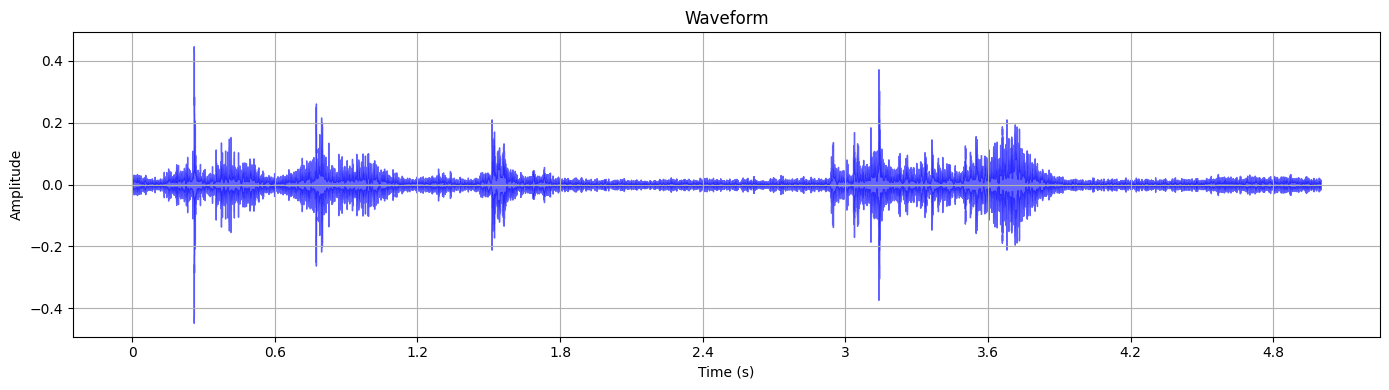

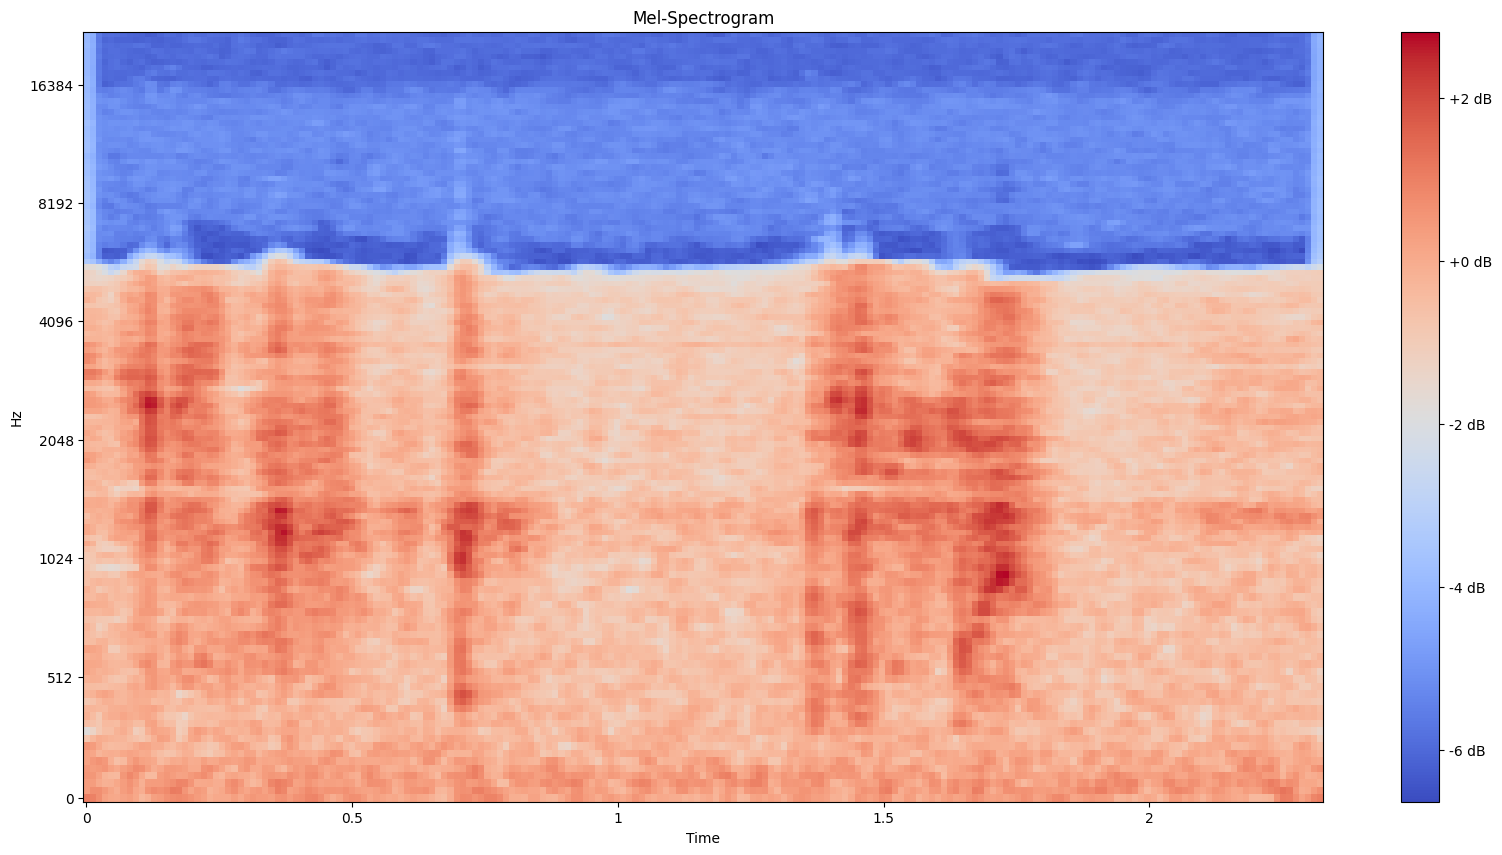

In [3]:
import librosa
import matplotlib.pyplot as plt

train_loader, val_loader = data_module.get_fold_dataloaders(1)

if dataset_config.dataset_type == "esc50":
    ic("Dataset type is ESC50")
    len(data_module.train_dataloader().dataset.file_names)
elif dataset_config.dataset_type == "uav":
    ic("Dataset type is UAV")
    len(train_loader.dataset.paths)

idx = 60
# class_map = data_module.train_dataloader().dataset.idx_to_class
# ic("sample's class: ", class_map[idx])
# sample_input, class = data_module.train_dataloader().dataset[idx]
sample_input, class_index = train_loader.dataset[idx]

audio = train_loader.dataset.audio_tensors[idx]
sample_input = sample_input.squeeze(0)  # remove batch dimension if needed
ic("sample's class: ", class_index)
ic("sample's input shape: ", sample_input.shape)
ic("sample's path: ", train_loader.dataset.paths[idx])
sr = 16000
raw_audio = audio.numpy()  # Convert to numpy array if it's a tensor
print(raw_audio.shape)
# Calculate the maximum amplitude across both audio signals
max_amplitude = ((np.abs(raw_audio)))

plt.figure(figsize=(14, 4))
librosa.display.waveshow(raw_audio, sr=sr, alpha=0.6, color='b')
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.grid(True)
plt.show()
if dataset_config.dataset_type == "esc50":
    data_module.train_dataloader().dataset.show_spectrogram(sample_input)
elif dataset_config.dataset_type == "uav":
    train_loader.dataset.show_spectrogram(sample_input)